////////////////////////////////////////////////////////////// Before PCA ////////////////////////// 


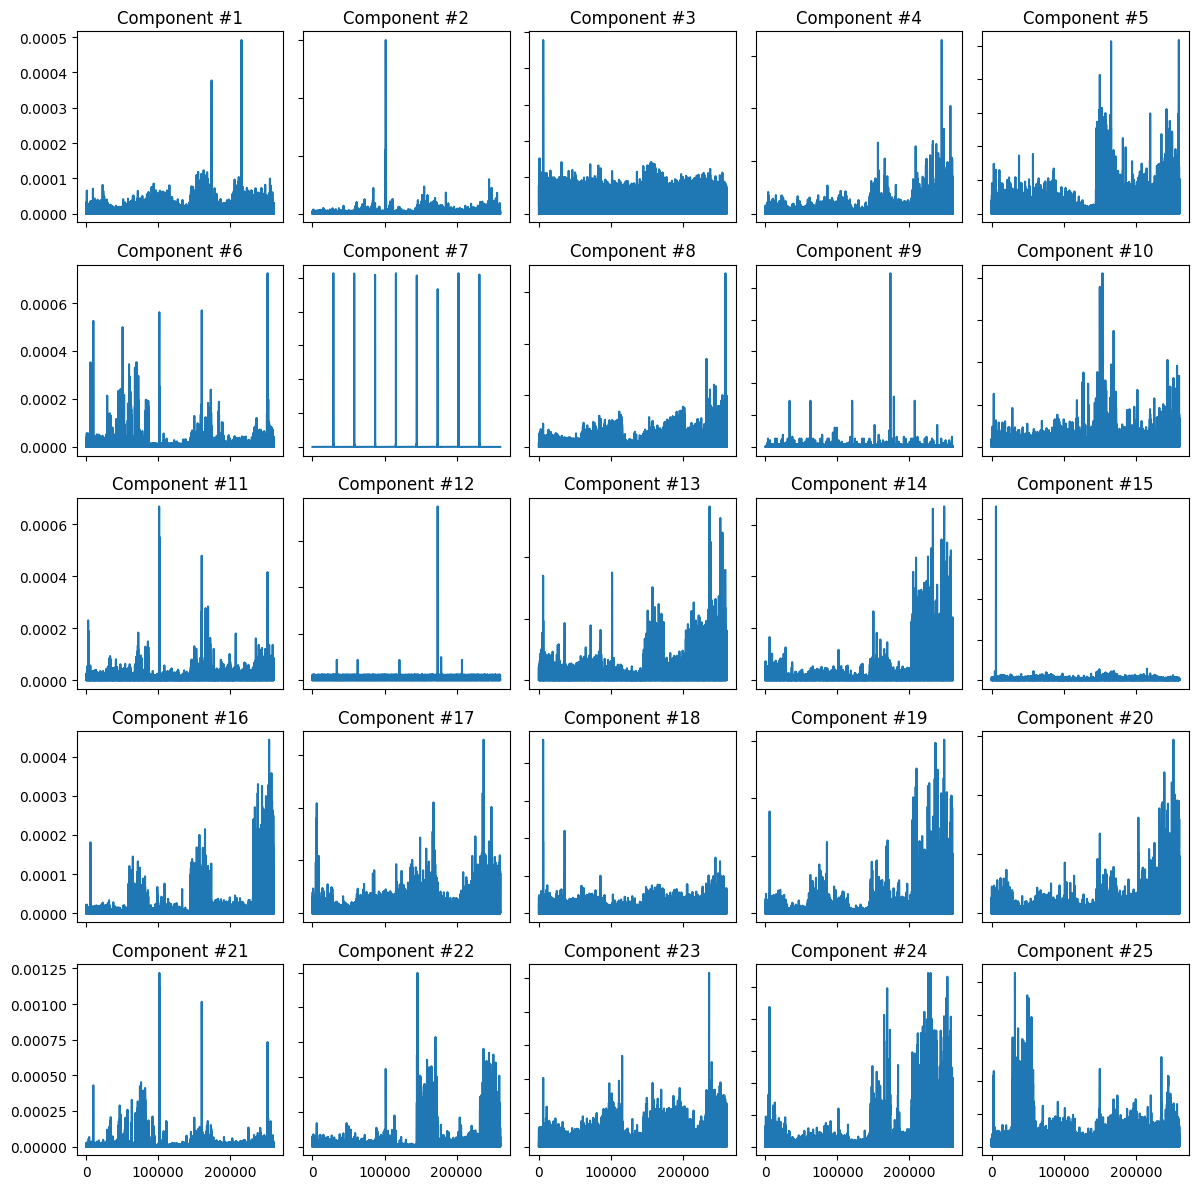

////////////////////////////////////////////////////////////// After PCA ////////////////////////// 


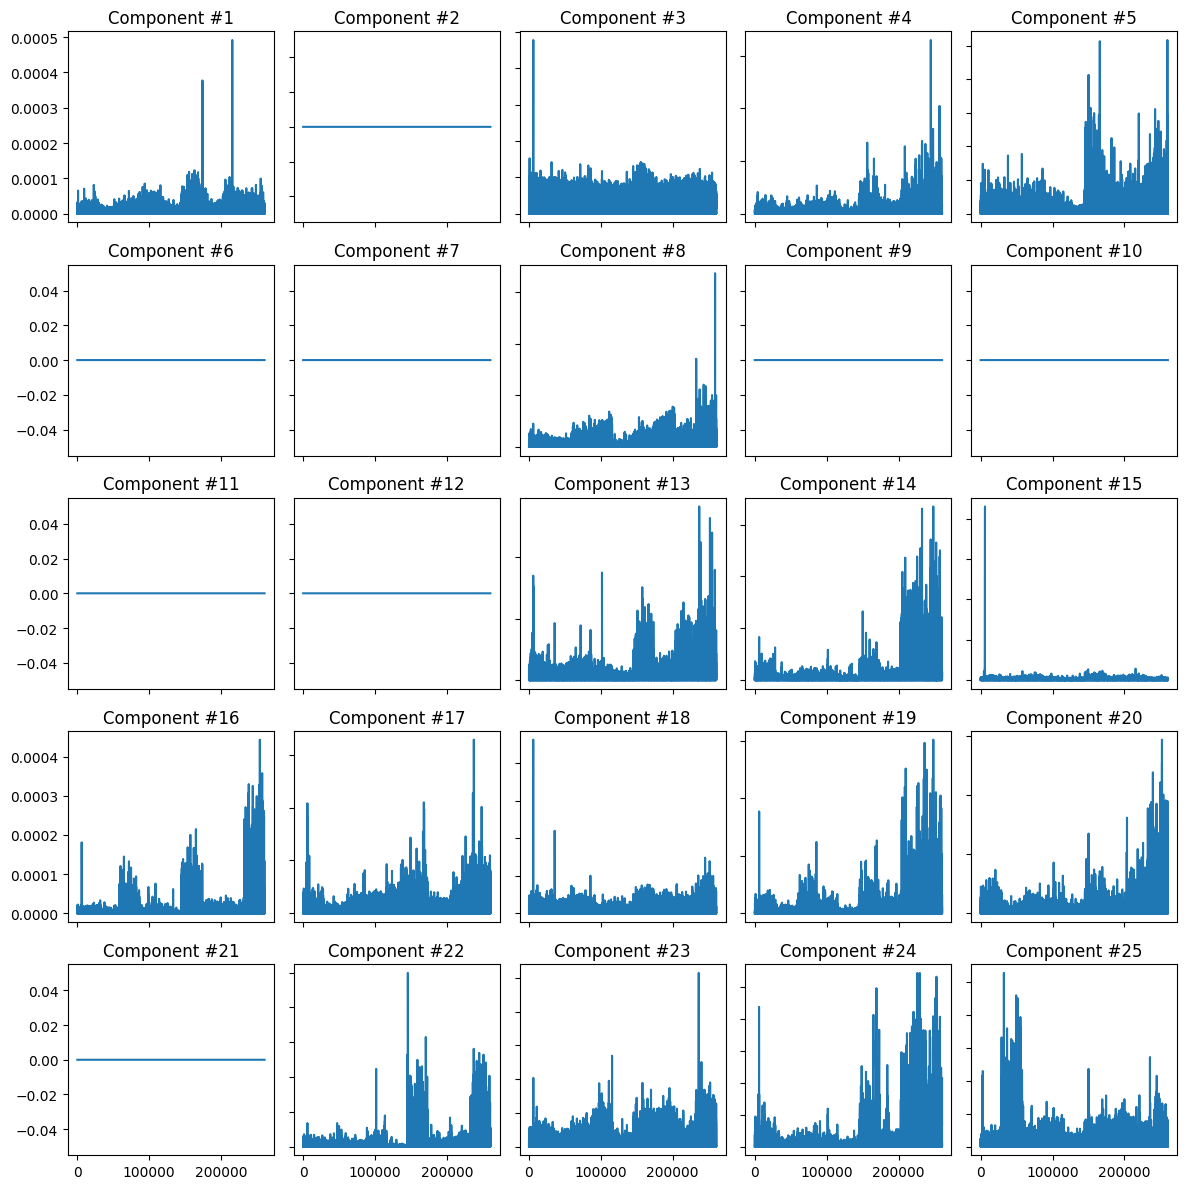

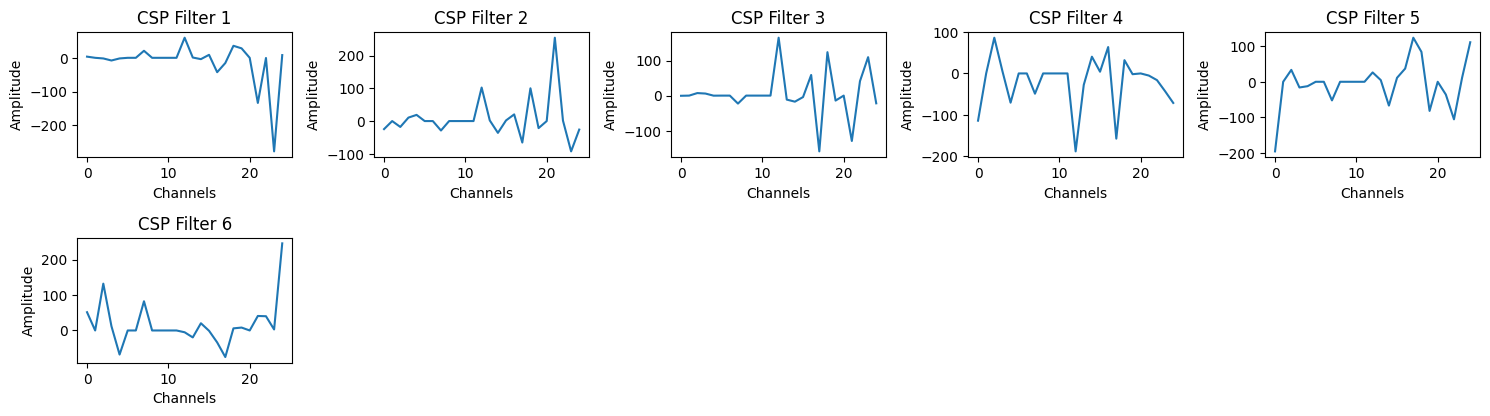

Sum of Variance Ratios: 0.06998089674220556
Test Accuracy of XGBoost: 0.5192132976749543
----------------------------------------------
KNN Training Accuracy: 0.6913028456733591
KNN Test Accuracy: 0.5090020345749786
----------------------------------------------


In [ ]:
import pickle
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, FastICA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import xgboost as xgb
# Load the EEG eye state classification dataset
data = pd.read_csv("filtered_file.csv")

# Split the dataset into features (X) and target (y)
X = data.drop(columns=['label'])  # Features
y = data['label']  # Target

# Drop rows with NaN values
data.dropna(inplace=True)

# Drop columns with NaN values
data.dropna(axis=1, inplace=True)

# Apply high-pass filter to EEG signals
fs = 200  # Sampling frequency
highcut = 4.0  # Higher cutoff frequency (Hz)
def highpass_filter(data, highcut, fs, order=4):
    nyquist = 0.5 * fs
    high = highcut / nyquist
    b, a = butter(order, high, btype='high')
    y = filtfilt(b, a, data)
    return y

X = highpass_filter(X.T, highcut, fs).T

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

'''pca = PCA(n_components=25) # Specify the number of components you want to keep
X = pca.fit_transform(X)

# Apply dimensionality reduction using ICA
ica = FastICA(n_components=25)  # Specify the number of components you want to estimate
X_ica = ica.fit_transform(X)'''


#Load X_ica from the saved .npy file
X_ica = np.load('x_ica.npy')

num_components = min(25, X_ica.shape[1]) # Number of components to plot (maximum 25)

fig, ax = plt.subplots(5, 5, figsize=(12, 12))

row = 0
col = 0
count = 0

for i in range(num_components):
    ax[row, col].plot(X_ica[:, i] ** 2)
    ax[row, col].set_title("Component #" + str(i + 1))
    count += 1
    col += 1
    if count % 5 == 0:
        row += 1
        col = 0

for ax in fig.get_axes():
    ax.label_outer()

print("////////////////////////////////////////////////////////////// Before PCA ////////////////////////// ")
fig.tight_layout()
plt.show()
#Save X_ica to a .npy file
#np.save('x_ica.npy', X_ica)


for i in range(X_ica.shape[0]):
    X_ica[i, 1]=0
    X_ica[i, 5] = 0
    X_ica[i,6]=0
    X_ica[i, 8] = 0
    X_ica[i, 9] = 0
    X_ica[i,10]=0
    X_ica[i,11]=0
    X_ica[i,20]=0
fig, ax = plt.subplots(5, 5, figsize=(12, 12))

row = 0
col = 0
count = 0

for i in range(num_components):
    ax[row, col].plot(X_ica[:, i] ** 2)
    ax[row, col].set_title("Component #" + str(i + 1))
    count += 1
    col += 1
    if count % 5 == 0:
        row += 1
        col = 0

for ax in fig.get_axes():
    ax.label_outer()
print("////////////////////////////////////////////////////////////// After PCA ////////////////////////// ")

fig.tight_layout()
plt.show()


# Compute CSP filters
def compute_csp(X, y, n_components=6):
    # Separate EEG trials for each class
    class_0 = np.transpose(X[y == 'right'])
    class_1 = np.transpose(X[y == 'left'])

    # Compute class-wise covariance matrices
    cov_0 = np.cov(class_0)
    cov_1 = np.cov(class_1)

    # Add regularization to covariance matrices
    cov_0 += np.eye(cov_0.shape[0]) * 1e-6
    cov_1 += np.eye(cov_1.shape[0]) * 1e-6

    try:
        # Compute generalized eigenvalues and eigenvectors
        eigenvalues, eigenvectors = eigh(cov_0, cov_0 + cov_1)
    except np.linalg.LinAlgError as e:
        print("Error computing eigenvalues and eigenvectors:", e)
        return None

    # Sort eigenvectors based on eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Select top CSP filters
    csp_filters = sorted_eigenvectors[:, :n_components]

    return csp_filters
# Apply CSP filtering to training and testing data
csp_filters = compute_csp(X_ica, y)
X = np.dot(csp_filters.T, X.T).T  # Transpose X before applying filters and transpose the result back
# Plot all CSP filters
plt.figure(figsize=(15, 10))
for i in range(csp_filters.shape[1]):
    plt.subplot(5, 5, i+1)
    plt.plot(csp_filters[:, i])
    plt.title(f"CSP Filter {i+1}")
    plt.xlabel("Channels")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()
# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)



# Compute variance ratio
variances = np.var(X, axis=0)
overall_variance = np.var(X)
variance_ratio = variances / overall_variance
# Compute the sum of variance ratios
variance_ratio_sum = np.sum(variance_ratio)

print("Sum of Variance Ratios:", variance_ratio_sum)



# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'max_depth': 3,  # Maximum depth of a tree
    'eta': 0.1,  # Learning rate
    'objective': 'binary:logistic',  # Objective function for binary classification
    'eval_metric': 'logloss'  # Evaluation metric
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test set
y_pred = model.predict(dtest)
y_pred_binary = [round(value) for value in y_pred]

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_binary)
print("Test Accuracy of XGBoost:", accuracy)
print("----------------------------------------------")

# Initialize and train the KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
knn_classifier.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = knn_classifier.predict(X_train)
y_test_pred = knn_classifier.predict(X_test)

# Calculate accuracy
train_accuracy_KNN = accuracy_score(y_train, y_train_pred)
test_accuracy_KNN = accuracy_score(y_test, y_test_pred)
print("KNN Training Accuracy:", train_accuracy_KNN)
print("KNN Test Accuracy:", test_accuracy_KNN)
print("----------------------------------------------")


# # Initialize and train the SVM classifier
# svm_classifier = SVC(kernel='poly', C=2, gamma='auto')
# svm_classifier.fit(X_train, y_train)

# # Make predictions on the training and testing data
# y_train_pred_svm = svm_classifier.predict(X_train)
# y_test_pred_svm = svm_classifier.predict(X_test)

# # Calculate accuracy
# train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
# test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
# print("SVM Training Accuracy:", train_accuracy_svm)
# print("SVM Training Accuracy:", test_accuracy_svm)


In [ ]:
# Save the KNN model
with open('KNN_Model.pkl', 'wb') as file:
    pickle.dump(knn_classifier, file)

In [ ]:
# svm_classifier = SVC(kernel='linear', C=2, gamma='auto')
# svm_classifier.fit(X_train, y_train)

# # Make predictions on the training and testing data
# y_train_pred_svm = svm_classifier.predict(X_train)
# y_test_pred_svm = svm_classifier.predict(X_test)

# # Calculate accuracy
# train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
# test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
# print("SVM Training Accuracy:", train_accuracy_svm)
# print("SVM Training Accuracy:", test_accuracy_svm)

In [ ]:
import ipywidgets as widgets
from PIL import Image as PILImage
import io
import pickle
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
class PhotoViewerApp:
    def __init__(self, knn_model_path, X_test):
        self.image_widget = widgets.Image()

        # Create file upload widget
        self.file_upload = widgets.FileUpload(accept='image/*', multiple=True)
        self.file_upload.observe(self.on_upload_change, names='_counter')

        # Create previous and next buttons
        self.prev_button = widgets.Button(description='Previous')
        self.prev_button.on_click(self.prev_image)

        self.next_button = widgets.Button(description='Next')
        self.next_button.on_click(self.next_image)


        # Arrange buttons in a row
        self.controls_widget = widgets.HBox([self.prev_button, self.next_button])

        # Display widgets
        display(self.file_upload)
        display(self.image_widget)
        display(self.controls_widget)
        self.i=0
        self.current_index = 0
        self.images = []
        self.knn_model = self.load_knn_model(knn_model_path)
        self.X_test = X_test


    # Method to load the KNN model
    def load_knn_model(self, model_path):
        with open(model_path, 'rb') as file:
            knn_model = pickle.load(file)
        return knn_model

    # Method to handle file upload change
    def on_upload_change(self, change):
        if change['new'] > change['old']:
            for filename, file_info in self.file_upload.value.items():
                content = file_info['content']
                self.images.append(content)
            self.load_image(0)
        time.sleep(2)
        self.start_prediction()

    # Method to load an image
    def load_image(self, index):
        if 0 <= index < len(self.images):
            image_data = self.images[index]
            # Resize image to 150x150 pixels
            image = PILImage.open(io.BytesIO(image_data))
            image = image.resize((150, 150))
            with io.BytesIO() as output:
                image.save(output, format='PNG')
                resized_image_data = output.getvalue()
            self.image_widget.value = resized_image_data
            self.current_index = index

    # Method to display the next image
    def next_image(self, button=None):
        self.current_index = (self.current_index + 1) % len(self.images)
        self.load_image(self.current_index)

    # Method to display the previous image
    def prev_image(self, button=None):
        self.current_index = (self.current_index - 1) % len(self.images)
        self.load_image(self.current_index)


    def start_prediction(self, button=None):
          # Start prediction automatically without the need for a button click
          while self.i < len(self.X_test) and self.i < 8:
              # Take one sample from X_train for prediction
              current_sample = self.X_test[self.i]

              # Make prediction using the KNN model
              predicted_label = self.knn_model.predict(current_sample.reshape(1, -1))[0]
              if predicted_label == 0:
                 predicted_label='left'
              else:
                 predicted_label='right'
              # Display the predicted label
              print("Predicted Label for Sample {}: {}".format(self.i + 1, predicted_label))

              # Adjust the position of the image widget based on the predicted label
              if predicted_label == 'left':
                  self.prev_image()
              elif predicted_label == 'right':
                  self.next_image()

              # Move to the next sample index for the next prediction
              self.i += 1

              # Introduce a delay of 1 second between predictions
              time.sleep(1)

          print("All {} samples from X_test have been predicted.".format(self.i))

# Load the trained KNN model
knn_model_path = 'KNN_Model.pkl'

# Create the PhotoViewerApp with the specified KNN model path, X_train, and y_train
app = PhotoViewerApp(knn_model_path, X_test)


FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Image(value=b'')

In [ ]:
y_test[:10]

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0])